In [1]:
import os
import yaml
import pandas as pd
import numpy as np

from evml.keras.models import CategoricalDNN
from bridgescaler import load_scaler

from evml.classifier_uq import brier_multi
import tensorflow as tf
from collections import defaultdict

import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.inspection import permutation_importance
from captum.attr import FeaturePermutation
from sklearn.metrics import accuracy_score, mean_squared_error

2023-08-03 08:11:07.512019: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-03 08:11:08.386848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 08:11:11.416171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
fn_config = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_weighted/model.yml"
#"/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/best.yml"

In [3]:
with open(fn_config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [4]:
input_features = (
    conf["TEMP_C"] + conf["T_DEWPOINT_C"] + conf["UGRD_m/s"] + conf["VGRD_m/s"]
)
output_features = conf["ptypes"]

### Load a pre-trained model 

In [5]:
model = CategoricalDNN.load_model(conf)

2023-08-03 08:11:27.856983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (3097, 84)                7140      
                                                                 
 dense_00 (Dense)            (3097, 200)               17000     
                                                                 
 dropout_00 (Dropout)        (3097, 200)               0         
                                                                 
 dense_01 (Dense)            (3097, 200)               40200     
                                                                 
 dropout_01 (Dropout)        (3097, 200)               0         
                                                                 
 dense_02 (Dense)            (3097, 200)               40200     
                                                                 
 dropout_02 (Dropout)        (3097, 200)               0

### Load the data pre-processing objects

In [7]:
input_scaler_loc = os.path.join(conf["save_loc"], "scalers", "input.json")

input_scaler = load_scaler(input_scaler_loc)

### Load test data split

##### Get the best model

In [8]:
import sys
sys.path.append("/glade/scratch/schreck/repos/evidential/applications/")
from evaluate_ptype import locate_best_model

In [9]:
best_split = locate_best_model(conf["save_loc"], conf["metric"], conf["direction"])

In [10]:
test_data_loc = os.path.join(conf["save_loc"], "evaluate", f"test_{best_split}.parquet")
test_data = pd.read_parquet(test_data_loc)

In [11]:
test_data_loc

'/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_weighted/evaluate/test_1.parquet'

In [12]:
y_true = test_data[output_features].values 

##### Predict with the model

In [13]:
scaled_input_x = input_scaler.transform(test_data[input_features])

In [14]:
y_pred_test = model.predict(scaled_input_x)

## Calculating SHAP values 

In [15]:
train_path = '/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/evaluate/train_1.parquet'
train_data = pd.read_parquet(train_path)
train_data = train_data[input_features]

test_path = '/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/evaluate/test_1.parquet'
test_data = pd.read_parquet(train_path)
test_data = train_data[input_features]

# randomize data: 
rand_data = train_data.sample(frac=0.1).values
explainer = shap.Explainer(model.model, rand_data)
#shap_values = explainer.shap_values(rand_data)
#np.save("/glade/work/saavedrab/ptype-physical/notebooks/xai_vals/shap_10.npy", shap_values)

In [16]:
shap_values = np.load('/glade/work/saavedrab/ptype-physical/notebooks/xai_vals/shap_50.npy') #50% of the data 
shap_values.shape # axis 0 = observattions, axis 2 = outputs 

(371929, 84, 4)

### TOP 10 FEATURES, SHAP 

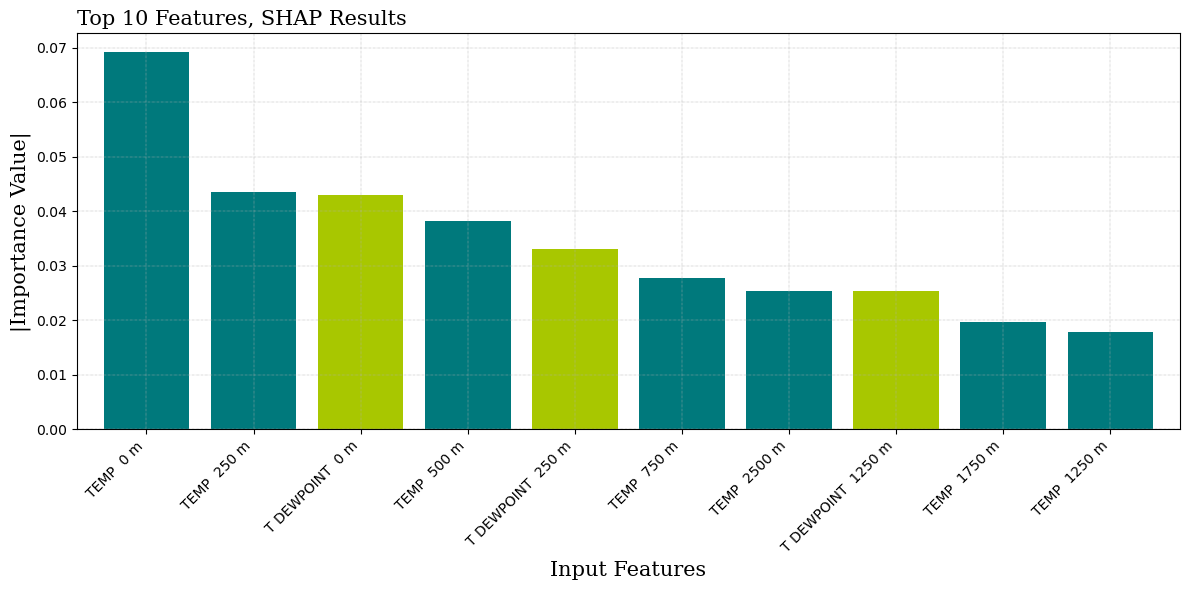

In [19]:
abs_imp = np.abs(shap_values) 
abs_imp = abs_imp.mean(axis=(0,2)) # taking the mean of the shap vals across all the observations and outputs
normalized_importance = abs_imp / abs_imp.sum() # normalizing by the sum 

feature_column_names = train_data.columns
feature_column_names = [name.replace('_', ' ').replace('C', '') for name in feature_column_names]

importance_df_shap = pd.DataFrame({'Feature': feature_column_names, 'SHAP Values': normalized_importance})

importance_df_shap = importance_df_shap.sort_values(by='SHAP Values', ascending=False)

shap_top_10 = importance_df_shap.head(10)

features = ['TEMP','T DEW']

fig, ax = plt.subplots(figsize=(12, 6))


# changing color per feature label
colors = []  
for feature in shap_top_10['Feature']:
    if feature[:len(features[0])] == features[0]: 
        colors.append('#00797C')
    elif feature[:len(features[1])] == features[1]:
        colors.append('#A8C700')

shap_top_10.plot.bar(x='Feature', y='SHAP Values', ax=ax, color=colors, width = 0.8, legend =None)


plt.title('Top 10 Features, SHAP Results',fontfamily='serif', loc ='left', size=15)
#plt.title('50% of the data',fontfamily='serif', loc ='right', size=15)
plt.xlabel('Input Features',fontfamily='serif', size=15)
plt.ylabel('|Importance Value|',fontfamily='serif', size=15)

plt.grid(linestyle='-.', linewidth=0.3, zorder=0)
#plt.xlim(-0.4, len(shap_top_10) - 0.6)
plt.xticks(rotation=45, ha='right')

plt.tight_layout() 
plt.savefig('/glade/work/saavedrab/ptype-physical/notebooks/figures_xai/shap_top10.png', dpi=300 )

plt.show()

### SHAP by height 

In [20]:
importance_df_shap

,Feature,SHAP Values
0,TEMP 0 m,0.069212
1,TEMP 250 m,0.043487
21,T DEWPOINT 0 m,0.042974
2,TEMP 500 m,0.038149
22,T DEWPOINT 250 m,0.033115
...,...,...
58,UGRD m/s 4000 m,0.004227
64,VGRD m/s 250 m,0.003429
70,VGRD m/s 1750 m,0.002484
63,VGRD m/s 0 m,0.001586


In [21]:
# extract height 
importance_df_shap['H'] = importance_df_shap['Feature'].str.extract(r'(\d+)')
# Convert the numbers  to integers
importance_df_shap['H'] = importance_df_shap['H'].astype(int)

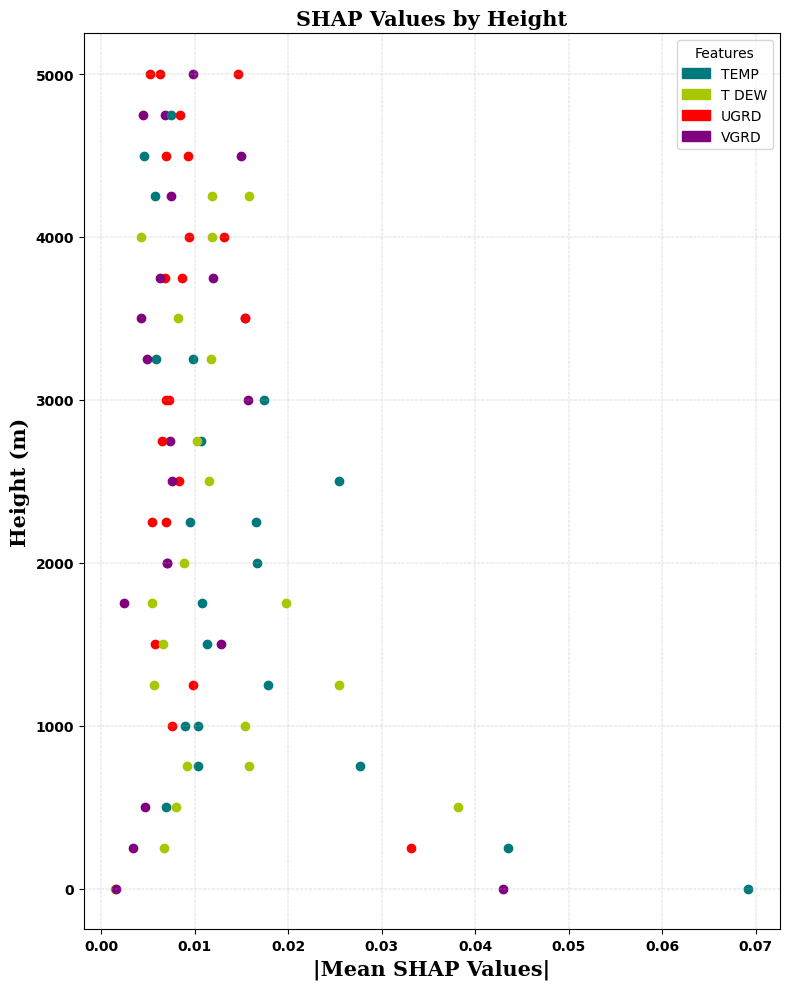

In [22]:
import matplotlib.patches as mpatches

colors = [] 
legend_labels = ['TEMP', 'T DEW', 'UGRD', 'VGRD']
legend_colors = ['#00797C', '#A8C700', 'red', 'purple']

plt.figure(figsize=(8, 10))  
for i, feature in enumerate(importance_df_shap['Feature']):
    for j, label in enumerate(legend_labels):
        if feature.startswith(label):
            plt.scatter(importance_df_shap['SHAP Values'][i], importance_df_shap['H'][i], marker='o', color=legend_colors[j], label='_nolegend_')

plt.xlabel('|Mean SHAP Values|',fontfamily='serif', size=15, fontweight = 'bold')
plt.ylabel('Height (m)',fontfamily='serif', size=15, fontweight = 'bold')
plt.title('SHAP Values by Height',fontfamily='serif', size=15, fontweight = 'bold')
plt.grid(linestyle='-.', linewidth=0.3, zorder=0)

legend_patches = [mpatches.Circle((0, 0), 0.1, color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# Add legend with custom proxy artists
plt.legend(handles=legend_patches, title='Features', loc='upper right')

plt.tight_layout()
plt.show()

## Permutation Feature importance 

In [24]:
# DJ's function:  

def feature_importance(x, y, model, metric_function, x_columns=None, permutations=5, processes=1,
                       col_start="perm_", seed=8272):
    """
    Calculate permutation feature importance scores for an arbitrary machine learning model.

    Args:
        x: ndarray of dimension (n_examples, n_features) that contains the input data for the ML model.
        y: ndarray of dimension (n_examples, ) that contains the true target values.
        model: machine learning model object in scikit-learn format (contains fit and predict methods).
        metric_function: scoring function with the input format (y_true, y_predicted) to match scikit-learn.
        x_columns (ndarray or None): list or array of column names. If not provided, indices will be used instead.
        permutations (int): Number of times a column is randomly shuffled.
        processes (int): Number of multiprocessor processes used for parallel computation of importances
        col_start (str): Start of output columns.
        seed (int): Random seed.

    Returns:
        pandas DataFrame of dimension (n_columns, permutations) that contains the change in score
        for each column and permutation.
    """
    if x_columns is None:
        x_columns = np.arange(x.shape[1])
    if type(x_columns) == list:
        x_columns = np.array(x_columns)
    predictions = model.predict(x)
    score = metric_function(y, predictions)
    print(score)
    np.random.seed(seed=seed)
    perm_matrix = np.zeros((x_columns.shape[0], permutations))

    def update_perm_matrix(result):
        perm_matrix[result[0]] = result[1]
    if processes > 1:
        pool = Pool(processes)
        for c in range(len(x_columns)):
            pool.apply_async(feature_importance_column,
                             (x, y, c, permutations, deepcopy(model), metric_function, np.random.randint(0, 100000)),
                              callback=update_perm_matrix)
        pool.close()
        pool.join()
    else:
        for c in range(len(x_columns)):
            result = feature_importance_column(x, y, c, permutations, model,
                                               metric_function, np.random.randint(0, 100000))
            update_perm_matrix(result)
    diff_matrix = score - perm_matrix
    out_columns = col_start + pd.Series(np.arange(permutations)).astype(str)
    return pd.DataFrame(diff_matrix, index=x_columns, columns=out_columns)

def feature_importance_column(x, y, column_index, permutations, model, metric_function, seed):
    """
    Calculate the permutation feature importance score for a single input column. It is the error score on
    a given set of data after the values in one column have been shuffled among the different examples.

    Args:
        x: ndarray of dimension (n_examples, n_features) that contains the input data for the ML model.
        y: ndarray of dimension (n_examples, ) that contains the true target values.
        column_index: Index of the x column being permuted
        permutations: Number of permutations run to calculate importance score distribution
        model: machine learning model object in scikit-learn format (contains fit and predict methods).
        metric_function: scoring function with the input format (y_true, y_predicted) to match scikit-learn.
        seed (int): random seed.

    Returns:
        column_index, permutation, perm_score
    """
    try:
        rs = np.random.RandomState(seed=seed)
        perm_indices = np.arange(x.shape[0])
        perm_scores = np.zeros(permutations)
        x_perm = np.copy(x)
        for p in range(permutations):
            print(column_index, p)
            rs.shuffle(perm_indices)
            x_perm[np.arange(x.shape[0]), column_index] = x[perm_indices, column_index]
            perm_pred = model.predict(x_perm)
            perm_scores[p] = metric_function(y, perm_pred)
        return column_index, perm_scores
    except Exception as e:
        print(traceback.format_exc())
        raise e
        

In [29]:
train_path = '/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/evaluate/train_1.parquet'
train_data = pd.read_parquet(train_path)

y_train = train_data['true_label'] #target
X_data = train_data[input_features]   
target = pd.get_dummies(y_train)

target = target.values.astype(np.float32)

In [32]:
def accuracy_score(y_true, y_pred):
    ''' accuracy function'''
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total

In [33]:
#from sklearn.metrics import accuracy_score
#target = np.argmax((target), axis = 0)
#accuracy_score(train_data['true_label'], train_data['pred_label'])
#permu_val = feature_importance(X_data.values, target, model, accuracy_score, permutations=10)
#np.argmax(your_array), axis = 1)

In [26]:
permu_values = np.load('/glade/work/saavedrab/ptype-physical/notebooks/xai_vals/perm_10.npy')

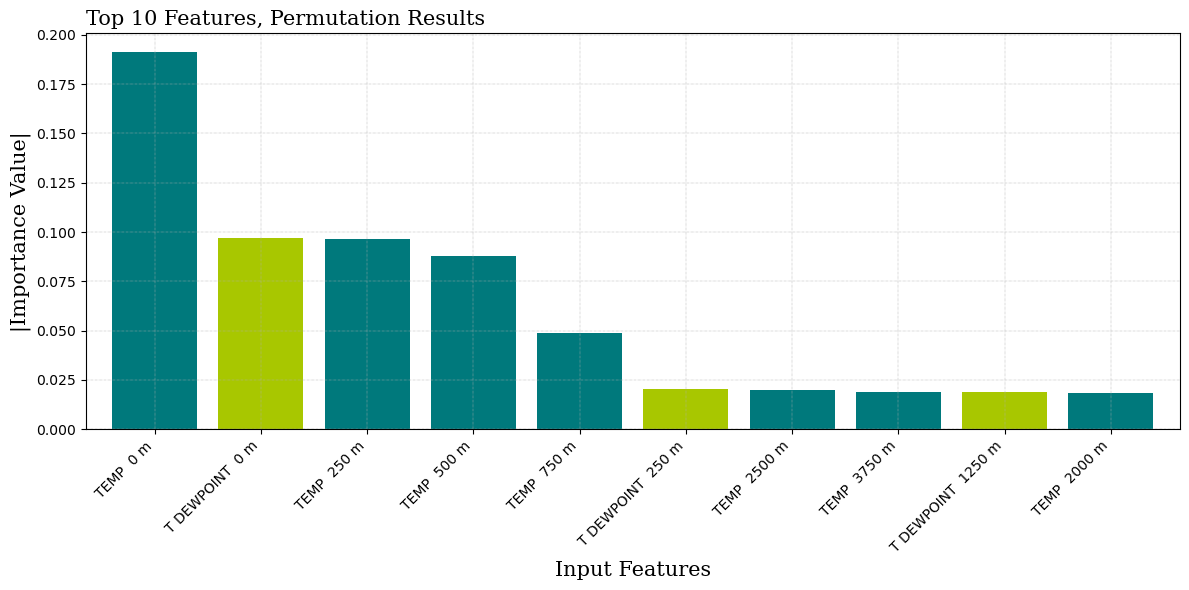

In [29]:
abs_importance = np.abs(permu_values)
abs_importance = abs_importance.mean(axis=1)

normalized_importance = abs_importance / abs_importance.sum()

feature_column_names = train_data.columns
feature_column_names = [name.replace('_', ' ').replace('C', '') for name in feature_column_names]

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_column_names, 'Permutation Values': normalized_importance})
# Sort the DataFrame by normalized importance in descending order
importance_df = importance_df.sort_values(by='Permutation Values', ascending=False)

perm_top_10 = importance_df.head(10)

features = ['TEMP','T DEW']

# change colors per feature label
colors = []  
for feature in perm_top_10['Feature']:
    if feature[:len(features[0])] == features[0]: 
        colors.append('#00797C')
    elif feature[:len(features[1])] == features[1]:
        colors.append('#A8C700')
    
fig, ax = plt.subplots(figsize=(12, 6))

perm_top_10.plot.bar(x='Feature', y='Permutation Values', ax=ax, color=colors, legend =None, width = 0.8)

plt.title('Top 10 Features, Permutation Results', fontfamily='serif', loc = 'left', size =15)
#plt.title('10 Permutations', fontfamily='serif', loc = 'right',size= 15)

plt.xlabel('Input Features', fontfamily='serif', size =15)
plt.ylabel('|Importance Value|', fontfamily='serif', size =15)

#plt.xlim(-0.4, len(perm_top_10) - 0.6)
# Adding grid lines in the background of the bins
plt.grid(linestyle='-.', linewidth=0.3, zorder=0)
plt.xticks(rotation=45, ha='right') 
plt.savefig('/glade/work/saavedrab/ptype-physical/notebooks/figures_xai/permutation_top_10.png')
plt.tight_layout()
plt.show()

### Permutation by Height 

In [30]:
# Use regex to extract numbers from the strings in the 'my_column' column
importance_df['H'] = importance_df['Feature'].str.extract(r'(\d+)')

# Convert the 'numbers' column to integers
importance_df['H'] = importance_df['H'].astype(int)
importance_df

,Feature,Permutation Values,H
0,TEMP 0 m,0.191217,0
21,T DEWPOINT 0 m,0.096965,0
1,TEMP 250 m,0.096380,250
2,TEMP 500 m,0.088041,500
3,TEMP 750 m,0.049035,750
...,...,...,...
72,VGRD m/s 2250 m,0.000279,2250
68,VGRD m/s 1250 m,0.000267,1250
42,UGRD m/s 0 m,0.000241,0
23,T DEWPOINT 500 m,0.000237,500


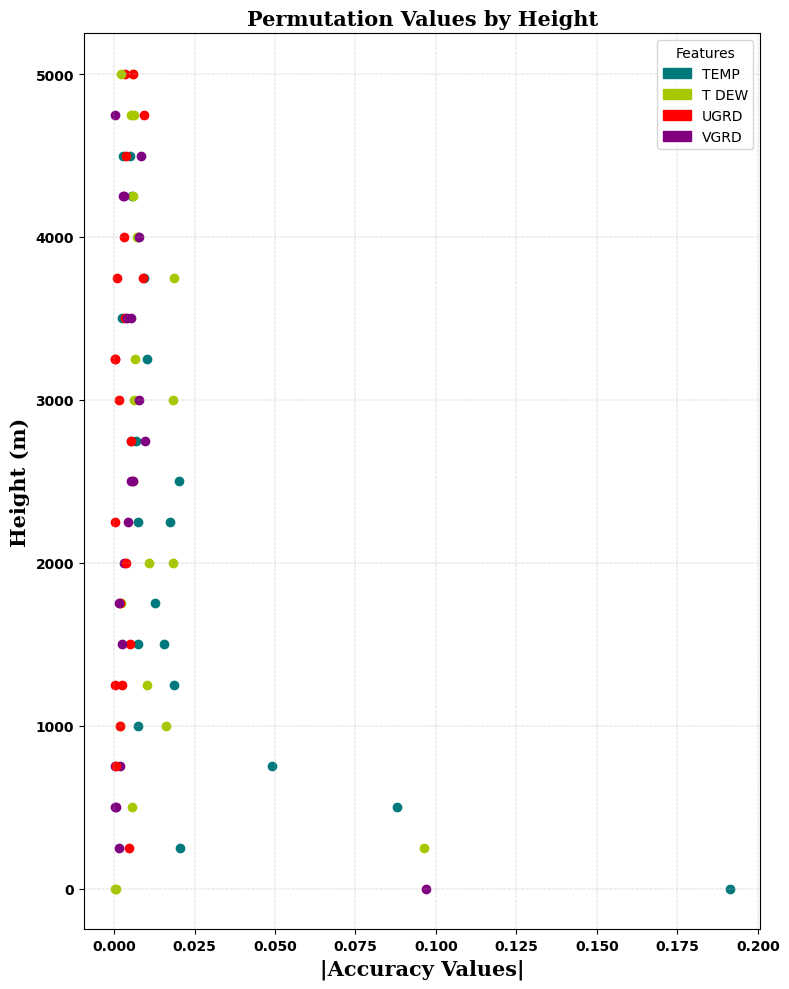

In [31]:
colors = [] 
legend_labels = ['TEMP', 'T DEW', 'UGRD', 'VGRD']
legend_colors = ['#00797C', '#A8C700', 'red', 'purple']

# Create the scatter plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
for i, feature in enumerate(importance_df['Feature']):
    for j, label in enumerate(legend_labels):
        if feature.startswith(label):
            plt.scatter(importance_df['Permutation Values'][i], importance_df['H'][i], marker='o', color=legend_colors[j], label='_nolegend_')

plt.xlabel('|Accuracy Values|',fontfamily='serif', size=15, fontweight = 'bold')
plt.ylabel('Height (m)',fontfamily='serif', size=15, fontweight = 'bold')
plt.title('Permutation Values by Height',fontfamily='serif', size=15, fontweight = 'bold')
plt.grid(linestyle='-.', linewidth=0.3, zorder=0)

# Create custom proxy artists for the legend
legend_patches = [mpatches.Circle((0, 0), 0.1, color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# Add legend with custom proxy artists
plt.legend(handles=legend_patches, title='Features', loc='upper right')

plt.tight_layout()
plt.show()

In [32]:
shap_top_10

,Feature,SHAP Values
0,TEMP 0 m,0.069212
1,TEMP 250 m,0.043487
21,T DEWPOINT 0 m,0.042974
2,TEMP 500 m,0.038149
22,T DEWPOINT 250 m,0.033115
3,TEMP 750 m,0.027693
10,TEMP 2500 m,0.025451
26,T DEWPOINT 1250 m,0.025436
7,TEMP 1750 m,0.019769
5,TEMP 1250 m,0.017872


In [33]:
perm_top_10

,Feature,Permutation Values
0,TEMP 0 m,0.191217
21,T DEWPOINT 0 m,0.096965
1,TEMP 250 m,0.096380
2,TEMP 500 m,0.088041
3,TEMP 750 m,0.049035
22,T DEWPOINT 250 m,0.020346
10,TEMP 2500 m,0.020042
15,TEMP 3750 m,0.018722
26,T DEWPOINT 1250 m,0.018720
8,TEMP 2000 m,0.018385


In [34]:
shap_ = shap_top_10['SHAP Values']
perm_ = perm_top_10['Permutation Values']

### Calculate the input * gradient

In [35]:
# Convert the input sample to a TensorFlow tensor
input_tensor = tf.convert_to_tensor(scaled_input_x)

# Open a gradient tape to track the operations
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    # Forward pass through the model
    output = model.model(input_tensor)

# Compute the gradients of the output with respect to the input
gradients = tape.gradient(output, input_tensor)

# Compute the XAI quantity: gradient * inputs
xai_quantity = gradients * input_tensor

xai_quantity = xai_quantity.numpy()

In [36]:
abs_GI = np.abs(xai_quantity)

top_10_indices = np.argsort(abs_GI.mean(axis=0))[-10:]

# Get the top 10 absolute values and their corresponding labels
top_10_values = abs_GI[:, top_10_indices]
top_10_labels = [input_features[i] for i in top_10_indices]

top_10_indices = np.argsort(top_10_values[0, :])[::-1]
sorted_top_10_values = top_10_values[:, top_10_indices]
sorted_top_10_labels = [top_10_labels[i] for i in top_10_indices]

top_10_GI = pd.DataFrame({'labels': sorted_top_10_labels, 'values': sorted_top_10_values[0]})


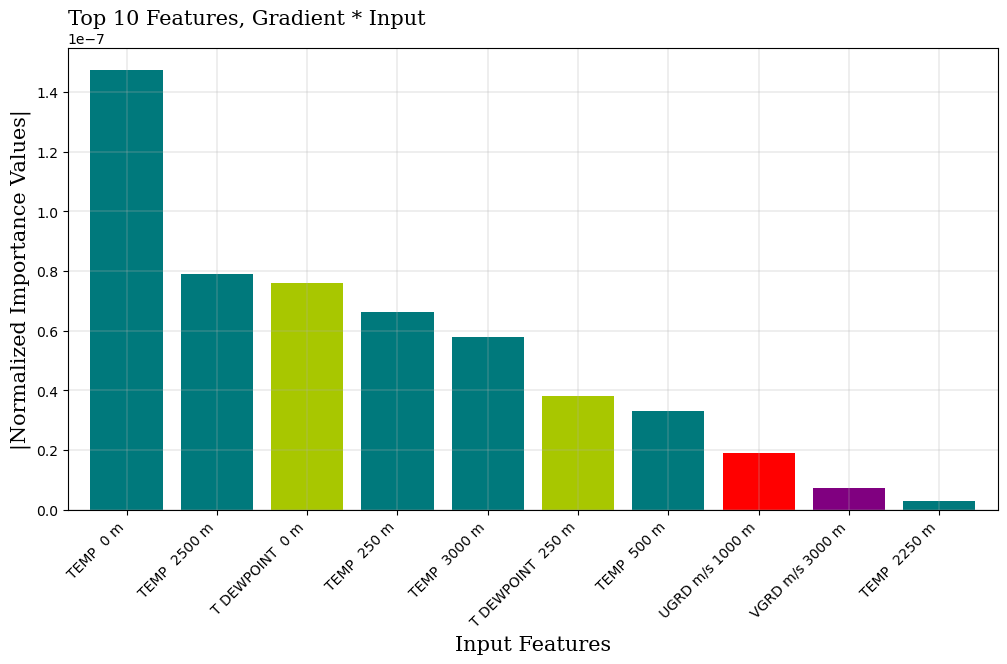

In [38]:
abs_GI = np.abs(xai_quantity)

top_10_indices = np.argsort(abs_GI.mean(axis=0))[-10:]

# Get the top 10 absolute values and their corresponding labels
top_10_values = abs_GI[:, top_10_indices]
top_10_labels = [input_features[i] for i in top_10_indices]

top_10_indices = np.argsort(top_10_values[0, :])[::-1]
sorted_top_10_values = top_10_values[:, top_10_indices]
sorted_top_10_labels = [top_10_labels[i] for i in top_10_indices]

top_10_GI = pd.DataFrame({'labels': sorted_top_10_labels, 'values': sorted_top_10_values[0]})

#normalize vals
min_value = top_10_GI['values'].min()
max_value = top_10_GI['values'].max()
top_10_GI['values_normalized'] = (top_10_GI['values'] - min_value) / (max_value - min_value)
top_10_GI['labels'] = [name.replace('_', ' ').replace('C', '') for name in top_10_GI['labels']]


fig, ax = plt.subplots(figsize=(12, 6))

features = ['TEMP', 'T DEW', 'UGRD', 'VGRD']

# change colors per feature label
colors = []  
for feature in top_10_GI['labels']:
    if feature[:len(features[0])] == features[0]: 
        colors.append('#00797C')
    elif feature[:len(features[1])] == features[1]:
        colors.append('#A8C700')
        
    elif feature[:len(features[2])] == features[2]:
        colors.append('red')
    
    elif feature[:len(features[3])] == features[3]: 
        colors.append('purple')
        


top_10_GI.plot.bar(x='labels', y='values', ax=ax, color=colors, width = 0.8, legend =None)

plt.title('Top 10 Features, Gradient * Input', fontfamily='serif', loc='left', size=15)
plt.xlabel('Input Features', fontfamily='serif', size=15)
plt.ylabel('|Normalized Importance Values|', fontfamily='serif', size=15)

plt.grid(linestyle='-', linewidth=0.3, zorder=0)
plt.xticks(rotation=45, ha='right')
plt.savefig('/glade/work/saavedrab/ptype-physical/notebooks/figures_xai/GI_top10.png')

plt.show()

## GI by Height 

In [39]:
# add the label and values columns 
GI_df = pd.DataFrame({'Features': input_features, 'GI Values': abs_GI[0,:]})

In [40]:
GI_df['H'] = GI_df['Features'].str.extract(r'(\d+)')

# Convert the 'numbers' column to integers
GI_df['H'] = GI_df['H'].astype(int)
GI_df

,Features,GI Values,H
0,TEMP_C_0_m,1.475172e-07,0
1,TEMP_C_250_m,6.609614e-08,250
2,TEMP_C_500_m,3.315579e-08,500
3,TEMP_C_750_m,2.137767e-08,750
4,TEMP_C_1000_m,2.843500e-09,1000
...,...,...,...
79,VGRD_m/s_4000_m,2.655712e-09,4000
80,VGRD_m/s_4250_m,1.242723e-09,4250
81,VGRD_m/s_4500_m,4.576308e-09,4500
82,VGRD_m/s_4750_m,1.209190e-08,4750


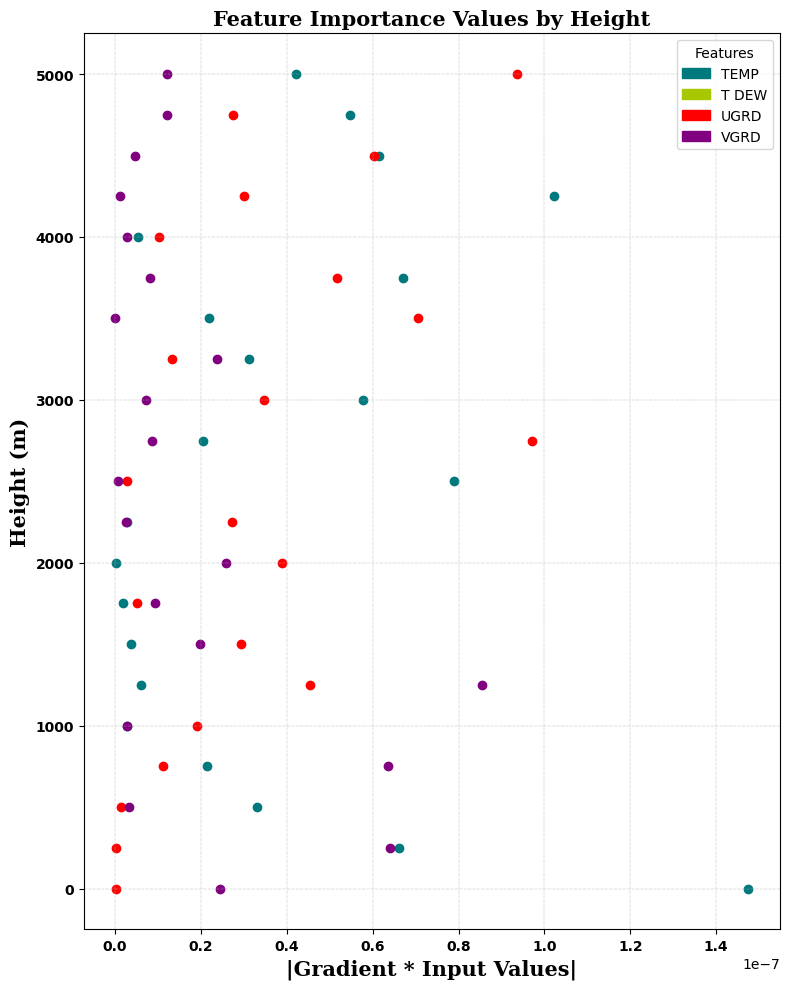

In [41]:
colors = [] 
legend_labels = ['TEMP', 'T DEW', 'UGRD', 'VGRD']
legend_colors = ['#00797C', '#A8C700', 'red', 'purple']

# Create the scatter plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
for i, feature in enumerate(GI_df['Features']):
    for j, label in enumerate(legend_labels):
        if feature.startswith(label):
            plt.scatter(GI_df['GI Values'][i], GI_df['H'][i], marker='o', color=legend_colors[j], label='_nolegend_')

plt.xlabel('|Gradient * Input Values|',fontfamily='serif', size=15, fontweight = 'bold')
plt.ylabel('Height (m)',fontfamily='serif', size=15, fontweight = 'bold')
plt.title('Feature Importance Values by Height',fontfamily='serif', size=15, fontweight = 'bold')
plt.grid(linestyle='-.', linewidth=0.3, zorder=0)

# Create custom proxy artists for the legend
legend_patches = [mpatches.Circle((0, 0), 0.1, color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# Add legend with custom proxy artists
plt.legend(handles=legend_patches, title='Features', loc='upper right')

plt.tight_layout()
plt.show()

In [42]:
unique_elements, counts = np.unique(np.argmax(xai_quantity, 1), return_counts=True)

# Sort the unique elements by count in descending order
sorted_indices = np.argsort(-counts)
sorted_elements = unique_elements[sorted_indices]
sorted_counts = counts[sorted_indices]

# Print the sorted unique elements and their counts
results = {} #defaultdict(list)
for element, count in zip(sorted_elements, sorted_counts):
    print(f"{input_features[element]}: {count}")
    results[input_features[element]] = count

TEMP_C_0_m: 314467
TEMP_C_3000_m: 10304
T_DEWPOINT_C_0_m: 8042
TEMP_C_2500_m: 5333
T_DEWPOINT_C_2500_m: 3459
VGRD_m/s_3000_m: 3195
TEMP_C_4250_m: 3094
T_DEWPOINT_C_250_m: 2887
UGRD_m/s_2500_m: 2210
UGRD_m/s_1500_m: 2195
UGRD_m/s_1000_m: 1975
VGRD_m/s_750_m: 1928
UGRD_m/s_3500_m: 1871
UGRD_m/s_2250_m: 1714
UGRD_m/s_500_m: 1667
VGRD_m/s_4500_m: 1607
UGRD_m/s_1250_m: 1564
T_DEWPOINT_C_1000_m: 1522
UGRD_m/s_2000_m: 1471
TEMP_C_500_m: 1421
UGRD_m/s_5000_m: 1368
VGRD_m/s_4250_m: 1197
VGRD_m/s_4750_m: 1180
T_DEWPOINT_C_1250_m: 1108
T_DEWPOINT_C_3500_m: 1079
TEMP_C_2250_m: 1015
UGRD_m/s_750_m: 976
UGRD_m/s_3750_m: 907
VGRD_m/s_500_m: 856
UGRD_m/s_250_m: 850
VGRD_m/s_2000_m: 834
VGRD_m/s_1250_m: 786
VGRD_m/s_4000_m: 754
UGRD_m/s_4000_m: 662
VGRD_m/s_3750_m: 658
UGRD_m/s_4250_m: 613
UGRD_m/s_2750_m: 522
VGRD_m/s_2750_m: 503
VGRD_m/s_0_m: 500
T_DEWPOINT_C_4250_m: 460
UGRD_m/s_0_m: 453
UGRD_m/s_4750_m: 449
VGRD_m/s_3250_m: 441
VGRD_m/s_2500_m: 432
UGRD_m/s_4500_m: 403
T_DEWPOINT_C_750_m: 387
TEMP_

In [43]:
xai_quantity.shape

(396696, 84)

In [44]:
'''fig, axs = plt.subplots(1, 4, figsize=(10, 4), sharey="row")

titles = ["TEMP_C", "T_DEWPOINT_C", "UGRD_m/s", "VGRD_m/s"]

for k, var in enumerate([conf["TEMP_C"], conf["T_DEWPOINT_C"], conf["UGRD_m/s"], conf["VGRD_m/s"]]):
    ydata = np.array([results[k] for k in var])
    axs[k].plot(var, ydata / sum(ydata))
    _var = [x.split("_")[-2] for x in var]
    _ = axs[k].set_xticks(var, _var, rotation=90, fontsize = 8)
    axs[k].set_yscale("log")
    axs[k].set_title(titles[k], fontsize = 10)

    axs[k].set_xlabel("Height above ground (m)")
axs[0].set_ylabel("Probability of being top-1 feature")
    
plt.tight_layout()'''

'fig, axs = plt.subplots(1, 4, figsize=(10, 4), sharey="row")\n\ntitles = ["TEMP_C", "T_DEWPOINT_C", "UGRD_m/s", "VGRD_m/s"]\n\nfor k, var in enumerate([conf["TEMP_C"], conf["T_DEWPOINT_C"], conf["UGRD_m/s"], conf["VGRD_m/s"]]):\n    ydata = np.array([results[k] for k in var])\n    axs[k].plot(var, ydata / sum(ydata))\n    _var = [x.split("_")[-2] for x in var]\n    _ = axs[k].set_xticks(var, _var, rotation=90, fontsize = 8)\n    axs[k].set_yscale("log")\n    axs[k].set_title(titles[k], fontsize = 10)\n\n    axs[k].set_xlabel("Height above ground (m)")\naxs[0].set_ylabel("Probability of being top-1 feature")\n    \nplt.tight_layout()'

## Stacked Histogram 

In [45]:
permu_values = np.load('/glade/work/saavedrab/ptype-physical/notebooks/xai_vals/perm_10.npy')
shap_values = np.load('/glade/work/saavedrab/ptype-physical/notebooks/xai_vals/shap_50.npy') #50% of the data 

In [47]:
#get the absolute val for each 
permu_values_abs = np.abs(permu_values[:, 0])
xai_quantity_abs = np.abs(xai_quantity[0, :])
shap_values_abs = np.abs(shap_values[0, :, 0])

#normalize GI
max_value = np.max(xai_quantity_abs)
xai_quantity_scaled = xai_quantity_abs / max_value
scale_factor =1  
xai_quantity_scaled *= scale_factor


#normalize permutation 
max_value = np.max(permu_values_abs)
perm_scaled = permu_values_abs / max_value
scale_factor = 1  
perm_scaled *= scale_factor

#normalize SHAP values 
max_value = np.max(shap_values_abs)
shap_scaled = shap_values_abs / max_value
scale_factor = 1 
shap_scaled *= scale_factor

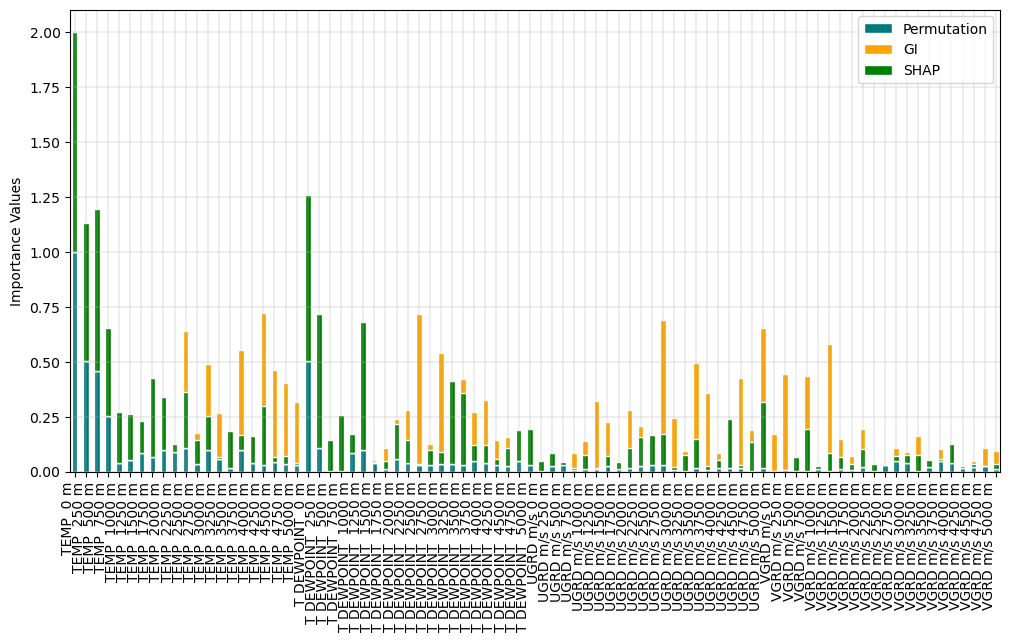

In [48]:
colors = ['#00797C', 'orange', 'green']
# The position of the bars on the x-axis
r = range(len(input_features))
barWidth = 0.5

# Plot bars
plt.figure(figsize=(12, 6))
ax1 = plt.bar(r, perm_scaled, color=colors[0], edgecolor='white', width=barWidth, label="Permutation")
ax2 = plt.bar(r, xai_quantity_scaled, bottom=perm_scaled, color=colors[1], edgecolor='white', width=barWidth, label='GI')
ax3 = plt.bar(r, shap_scaled, bottom=perm_scaled + xai_quantity_abs, color=colors[2], edgecolor='white', width=barWidth, label='SHAP')

input_features = [name.replace('_', ' ').replace('C', '') for name in input_features]

plt.legend()
plt.xticks(r, input_features, rotation=90, ha='right')
plt.ylabel("Importance Values" )
plt.xlim(-0.4, len(input_features) - 0.6)
plt.grid(linestyle='-', linewidth=0.3, zorder=0)
plt.show()

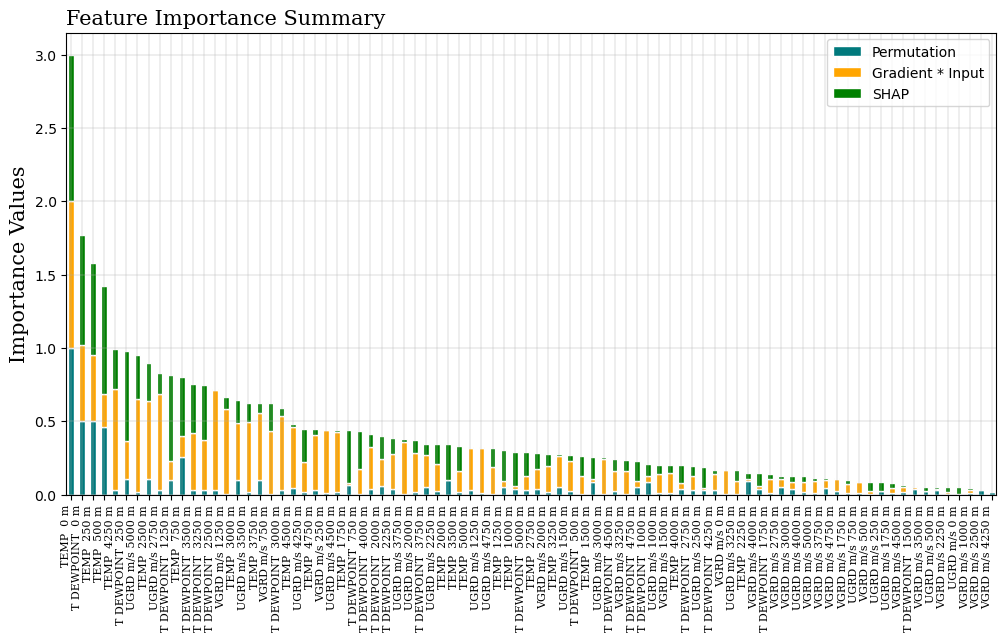

In [51]:
# tuples that contain the feature names and their importance values
importance_data = zip(input_features, perm_scaled, xai_quantity_scaled, shap_scaled)

importance_data = sorted(importance_data, key=lambda x: sum(x[1:]), reverse=True) #sorting by val

sorted_features, sorted_perm_scaled, sorted_xai_scaled, sorted_shap_scaled = zip(*importance_data)

colors = ['#00797C', 'orange', 'green']
r = range(len(input_features))
barWidth = 0.5

plt.figure(figsize=(12, 6))
ax1 = plt.bar(r, sorted_perm_scaled, color=colors[0], edgecolor='white', width=barWidth, label="Permutation")
ax2 = plt.bar(r, sorted_xai_scaled, bottom=sorted_perm_scaled, color=colors[1], edgecolor='white', width=barWidth, label='Gradient * Input')
ax3 = plt.bar(r, sorted_shap_scaled, bottom=np.array(sorted_perm_scaled) + np.array(sorted_xai_scaled), color=colors[2], edgecolor='white', width=barWidth, label='SHAP')

plt.legend()
plt.xticks(r, sorted_features, rotation=90, ha='right', size=8,fontfamily='serif')
plt.title("Feature Importance Summary", fontfamily='serif', size = 15, loc ='left')
plt.ylabel("Importance Values", fontfamily='serif', size = 15)
plt.xlim(-0.4, len(input_features) - 0.6)
plt.grid(linestyle='-', linewidth=0.3, zorder=0)
plt.savefig('/glade/work/saavedrab/ptype-physical/notebooks/figures_xai/stacked_vals_xai.png')
plt.show()